# Kinetic Modeling with PYthon (kmpy)

In [33]:
import os, sys
import numpy as np
from constants import GAS_CONST, PR_ATM
from constants import KCAL_JL, HT_JL
import pandas as pd
import math

In [34]:
cwd = os.getcwd()

setting up the paths for the input files

In [35]:
def set_paths(myPath):
    """
    Set the absolute path to required files on the current machine.

    Returns
    -------
    reactionlist_path     : str
                            path to the file `complete_reactionlist.dat`
    rateconstantlist_path : str
                            path to the file `complete_rateconstantlist.dat`
    free_enenry_path      : str
                            path to the file `compositionlist.dat`
    """
    #myPath = os.path.dirname(os.path.abspath(__file__))
#     reactionlist_path = myPath + '/data/complete_reaction_list.dat'
#     rateconstantlist_path = myPath + '/data/complete_rateconstant_list.dat'
#     free_energy_path = myPath + '/data/free_energy_library.dat'
    reactionlist_path = myPath + '/data/reaction_list.dat'
    rateconstantlist_path = myPath + '/data/rateconstant_list.dat'
    free_energy_path = myPath + '/../kinexns/data/free_energy_library.dat'
    return reactionlist_path, rateconstantlist_path, free_energy_path


In [36]:
file_reactionlist, file_rateconstantlist, file_free_energy = set_paths(cwd)

In [37]:
df_reaction = pd.read_csv(file_reactionlist, header = None)
df_reaction.head()

,0,1,2
0,-1.0_O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,1.0_O,1.0_OC1=COC[C@@H](O)[C@@H]1O
1,-1.0_O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,1.0_O,1.0_OC1=C[C@@H](O)[C@H](O)OC1
2,-1.0_O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,1.0_O,1.0_O[C@H]1C=CO[C@@H](O)[C@@H]1O
3,-1.0_O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,1.0_O=C[C@@H](O)[C@H](O)[C@@H](O)CO,NaN
4,-1.0_O[C@H]1C=CO[C@@H](O)[C@@H]1O,1.0_O=C[C@H](O)[C@@H](O)/C=C\O,NaN


In [38]:
df_rate = pd.read_csv(file_rateconstantlist, header = None, sep = ' ')
df_rate.head()

,0,1,2
0,5.000000e+15,0,57.0
1,5.000000e+15,0,57.0
2,6.000000e+15,0,59.0
3,3.000000e+13,0,47.0
4,9.000000e+12,0,46.1


In [39]:
df_free_energy = pd.read_csv(file_free_energy, sep = '\t')
df_free_energy.head()

,Structure ID,smiles,electronic_energy,300K,400K,500K,600K,700K,800K
0,1,O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,-572.654636,0.130831,0.114449,0.096034,0.075704,0.053580,0.029778
1,2,O,-76.422977,0.003836,-0.003547,-0.011258,-0.019238,-0.027448,-0.035861
2,3,OC1=COC[C@@H](O)[C@@H]1O,-496.193201,0.103466,0.088156,0.071087,0.052368,0.032109,0.010414
3,4,OC1=C[C@@H](O)[C@H](O)OC1,-496.205201,0.104026,0.088926,0.072080,0.053591,0.033566,0.012107
4,5,O[C@H]1C=CO[C@@H](O)[C@@H]1O,-496.204142,0.104043,0.088886,0.071984,0.053439,0.033355,0.011835


In [40]:
class Reaction(object):
    
    
    def __init__(self):
        self.reactants_names = []
        self.products_names = []
        self.uniqueSpeciesList = []
        #species_names = []
        
   
    def getReactantsName(self, line):
        
        for spec in line.split(','):
            if float(spec.split('_')[0].split()[0]) < 0:
                self.reactants_names.append((spec.split('_')[0].split()[0],
                                          spec.split('_')[1].split()[0]))
            #print(self.species_names)
        return self.reactants_names
    
    def getProductsName(self, line):
        
        for spec in line.split(','):
            if float(spec.split('_')[0].split()[0]) > 0:
                self.products_names.append((spec.split('_')[0].split()[0],
                                          spec.split('_')[1].split()[0]))
            #print(self.species_names)
        return self.products_names
    
    def uniqueSpeciesName(self, line, species_list):
        #self.uniqueSpeciesList = species_list
        for spec in line.split(','):
            #self.uniqueSpeciesList = species_list
            # If the species has already been added to the list then move on.
            if spec.split('_')[1].split()[0] in species_list:
                self.uniqueSpeciesList = species_list
                continue
            else:
                #print(self.uniqueSpeciesList)
                self.uniqueSpeciesList = species_list
                self.uniqueSpeciesList.append(spec.split('_')[1].split()[0])
            #print(spec.split('_')[1].split()[0])
        return self.uniqueSpeciesList
    

In [41]:
def build_species_list(reaction_file):
    """
    Build reactnat and product list for each reaction. Also builds a list
    of unique species in the mechanism
    Parameters
    ----------
    reaction_file       : str
                           path to the file `complete_reaction_list.dat`
    Returns
    __________

    reactant_list       : list
                         a list of the reactants and their stoichiometric
                         coeffs for each reaction
    product_list        : list
                         a list of the products and their stoichiometric
                         coeffs for each reaction
    species_list        : list
                        a list of unique species in the mechanism
    """

    #initializing reactant, product and unique species list
    reactant_list = []
    product_list = []
    species_name = []

    for line in open(reaction_file, 'r').readlines():
        reac = Reaction()
        reactant_list.append(reac.getReactantsName(line))
        product_list.append(reac.getProductsName(line))
        current_species = species_name
        #print(current_species)
        species_list = reac.uniqueSpeciesName(line, current_species)
        #print(species_name)
    species_list.sort()

    return reactant_list, product_list, species_list

reactants_list, products_list, unique_species = build_species_list(file_reactionlist)
    

In [42]:
print(unique_species)
print(len(unique_species))

['C=C(O)C=O', 'C=C(O)[C@@H](O)[C@H](O)C=O', 'C=O', 'CC(=O)/C=C(/O)C=O', 'CC(=O)C=O', 'CC(=O)CC(=O)C=O', 'CC(=O)CO', 'CC(=O)[C@@H](O)[C@H](O)C=O', 'CC=O', 'O', 'O/C=C/O', 'O=C/C=C(\\O)[C@@H](O)CO', 'O=C/C=C/C(=O)CO', 'O=C/C=C\\[C@@H](O)C=O', 'O=C1COC=C[C@@H]1O', 'O=C1COCC(=O)C1', 'O=C1COC[C@@H](O)[C@@H]1O', 'O=CC(O)C=O', 'O=CC1=C[C@@H](O)CO1', 'O=CC=O', 'O=CCC(=O)[C@@H](O)CO', 'O=CCC=O', 'O=CCO', 'O=CC[C@H](O)[C@@H](O)C=O', 'O=CC[C@H](O)[C@H](O)C=O', 'O=C[C@@H](O)/C=C(\\O)CO', 'O=C[C@@H](O)CC(=O)CO', 'O=C[C@@H](O)[C@@H](O)/C=C\\O', 'O=C[C@@H](O)[C@@H](O)CO', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO', 'O=C[C@H](O)/C=C(/O)CO', 'O=C[C@H](O)CC(=O)CO', 'O=C[C@H](O)CO', 'O=C[C@H](O)[C@@H](O)/C=C\\O', 'O=C[C@H]1OC[C@H](O)[C@H]1O', 'O=Cc1ccco1', 'OC1=COC=C[C@@H]1O', 'OC1=COCC(O)=C1', 'OC1=COC[C@@H](O)[C@@H]1O', 'OC1=C[C@@H](O)[C@H](O)OC1', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']
42


In [43]:
#print(len(products_list))
print(products_list)

[[('1.0', 'O'), ('1.0', 'OC1=COC[C@@H](O)[C@@H]1O')], [('1.0', 'O'), ('1.0', 'OC1=C[C@@H](O)[C@H](O)OC1')], [('1.0', 'O'), ('1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O')], [('1.0', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO')], [('1.0', 'O=C[C@H](O)[C@@H](O)/C=C\\O')], [('1.0', 'O=CC[C@H](O)[C@@H](O)C=O')], [('1.0', 'O=CCO'), ('1.0', 'O=CCC=O')], [('1.0', 'O'), ('1.0', 'O=C/C=C\\[C@@H](O)C=O')], [('1.0', 'O'), ('1.0', 'OC1=COC=C[C@@H]1O')], [('1.0', 'O=C[C@H](O)/C=C(/O)CO')], [('1.0', 'O=C[C@H](O)CC(=O)CO')], [('1.0', 'O'), ('1.0', 'O=C/C=C/C(=O)CO')], [('1.0', 'CC(=O)CO'), ('1.0', 'O=CC=O')], [('1.0', 'O'), ('1.0', 'OC1=COCC(O)=C1')], [('1.0', 'O=C1COCC(=O)C1')], [('1.0', 'O'), ('1.0', 'OC1=COCC(O)=C1')], [('1.0', 'O=C1COC[C@@H](O)[C@@H]1O')], [('1.0', 'C=C(O)[C@@H](O)[C@H](O)C=O')], [('1.0', 'CC(=O)[C@@H](O)[C@H](O)C=O')], [('1.0', 'CC(=O)C=O'), ('1.0', 'O=CCO')], [('1.0', 'O'), ('1.0', 'CC(=O)/C=C(/O)C=O')], [('1.0', 'CC(=O)CC(=O)C=O')], [('1.0', 'O'), ('1.0', 'OC1=COC=C[C@@H]1O')], [('1.0', 'O=C1CO

In [44]:
reac_prod_list = [react + prod for react, prod in zip(reactants_list, products_list)]
# for react, prod in zip(reactants, products):
#     total.append(react + prod)
#print(total)

In [45]:
print(reac_prod_list)

[[('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'OC1=COC[C@@H](O)[C@@H]1O')], [('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'OC1=C[C@@H](O)[C@H](O)OC1')], [('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O')], [('-1.0', 'O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O'), ('1.0', 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO')], [('-1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O'), ('1.0', 'O=C[C@H](O)[C@@H](O)/C=C\\O')], [('-1.0', 'O=C[C@H](O)[C@@H](O)/C=C\\O'), ('1.0', 'O=CC[C@H](O)[C@@H](O)C=O')], [('-1.0', 'O=CC[C@H](O)[C@@H](O)C=O'), ('1.0', 'O=CCO'), ('1.0', 'O=CCC=O')], [('-1.0', 'O=CC[C@H](O)[C@@H](O)C=O'), ('1.0', 'O'), ('1.0', 'O=C/C=C\\[C@@H](O)C=O')], [('-1.0', 'O[C@H]1C=CO[C@@H](O)[C@@H]1O'), ('1.0', 'O'), ('1.0', 'OC1=COC=C[C@@H]1O')], [('-1.0', 'OC1=C[C@@H](O)[C@H](O)OC1'), ('1.0', 'O=C[C@H](O)/C=C(/O)CO')], [('-1.0', 'O=C[C@H](O)/C=C(/O)CO'), ('1.0', 'O=C[C@H](O)CC(=O)CO')], [('-1.0', 'O=C[C@H](O)CC(=O)CO'), (

In [46]:
#generating a dictionary of unique species from the species_list
speciesindices = {unique_species[i]: i for i in range(0, len(unique_species))}

indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))

In [47]:
speciesindices
#indices_to_species

{'C=C(O)C=O': 0,
 'C=C(O)[C@@H](O)[C@H](O)C=O': 1,
 'C=O': 2,
 'CC(=O)/C=C(/O)C=O': 3,
 'CC(=O)C=O': 4,
 'CC(=O)CC(=O)C=O': 5,
 'CC(=O)CO': 6,
 'CC(=O)[C@@H](O)[C@H](O)C=O': 7,
 'CC=O': 8,
 'O': 9,
 'O/C=C/O': 10,
 'O=C/C=C(\\O)[C@@H](O)CO': 11,
 'O=C/C=C/C(=O)CO': 12,
 'O=C/C=C\\[C@@H](O)C=O': 13,
 'O=C1COC=C[C@@H]1O': 14,
 'O=C1COCC(=O)C1': 15,
 'O=C1COC[C@@H](O)[C@@H]1O': 16,
 'O=CC(O)C=O': 17,
 'O=CC1=C[C@@H](O)CO1': 18,
 'O=CC=O': 19,
 'O=CCC(=O)[C@@H](O)CO': 20,
 'O=CCC=O': 21,
 'O=CCO': 22,
 'O=CC[C@H](O)[C@@H](O)C=O': 23,
 'O=CC[C@H](O)[C@H](O)C=O': 24,
 'O=C[C@@H](O)/C=C(\\O)CO': 25,
 'O=C[C@@H](O)CC(=O)CO': 26,
 'O=C[C@@H](O)[C@@H](O)/C=C\\O': 27,
 'O=C[C@@H](O)[C@@H](O)CO': 28,
 'O=C[C@@H](O)[C@H](O)[C@@H](O)CO': 29,
 'O=C[C@H](O)/C=C(/O)CO': 30,
 'O=C[C@H](O)CC(=O)CO': 31,
 'O=C[C@H](O)CO': 32,
 'O=C[C@H](O)[C@@H](O)/C=C\\O': 33,
 'O=C[C@H]1OC[C@H](O)[C@H]1O': 34,
 'O=Cc1ccco1': 35,
 'OC1=COC=C[C@@H]1O': 36,
 'OC1=COCC(O)=C1': 37,
 'OC1=COC[C@@H](O)[C@@H]1O': 38,
 'OC1=C[C@

In [48]:
reac_matrix = np.zeros((len(reac_prod_list),len(unique_species)), dtype = float)
reac_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
for rxnindex, reac_list in enumerate(reac_prod_list):
    for x in range (len(reac_list)):
        species = reac_list[x][1]
        for i in range (len(unique_species)):
            if i == speciesindices[species]:
                reac_matrix[rxnindex][i] = float(reac_list[x][0])

print(reac_matrix)
                

[[ 0.  0.  0. ...  0.  0. -1.]
 [ 0.  0.  0. ...  1.  0. -1.]
 [ 0.  0.  0. ...  0.  1. -1.]
 ...
 [ 0.  0.  1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [50]:
def build_reac_prod_dict(reac_list, prod_list, speciesindices):
    """
    Build a dictionary of the reactants involved in each reaction,
    along with their stoichiometric coefficients.  The keys of the
    dictionary are the reaction numbers, the values are lists of lists
    [[reactant1index, -1*coeff1],...]
    Parameters
    ----------
    completereactionlist : str
                           path to the file `complete_reaction_list.dat`
    speciesindices       : dict
                           the dictionary speciesindices from
                           get_speciesindices()
    Returns
    -------
    reactant_dict : dict
                    a dictionary where keys are reaction numbers and values
                    are lists of lists with the reactants and their
                    stoichiometric coefficients for each reaction
    """
    reactant_dict = {}
    for rxnindex, reaction in enumerate(reac_list):
        reactants = []
        #
        for x in range(len(reaction)):
            # if the species is a reactant
         #   if float(x.split('_')[0]) < 0:
            reactants.append([speciesindices[reaction[x][1]],
                                -1*float(reaction[x][0])])
            #    in preceding line: *-1 because I want the |stoich coeff|
        reactant_dict[rxnindex] = reactants
        
    products_dict = {}
    for rxnindex, reaction in enumerate(prod_list):
        products = []
        #
        for x in range(len(reaction)):
            # if the species is a reactant
         #   if float(x.split('_')[0]) < 0:
            products.append([speciesindices[reaction[x][1]],
                                1*float(reaction[x][0])])
            #    in preceding line: *-1 because I want the |stoich coeff|
        products_dict[rxnindex] = products
    return reactant_dict, products_dict

In [51]:
reac_dict, prod_dict = build_reac_prod_dict(reactants_list, products_list, speciesindices)
prod_dict

{0: [[9, 1.0], [38, 1.0]],
 1: [[9, 1.0], [39, 1.0]],
 2: [[9, 1.0], [40, 1.0]],
 3: [[29, 1.0]],
 4: [[33, 1.0]],
 5: [[23, 1.0]],
 6: [[22, 1.0], [21, 1.0]],
 7: [[9, 1.0], [13, 1.0]],
 8: [[9, 1.0], [36, 1.0]],
 9: [[30, 1.0]],
 10: [[31, 1.0]],
 11: [[9, 1.0], [12, 1.0]],
 12: [[6, 1.0], [19, 1.0]],
 13: [[9, 1.0], [37, 1.0]],
 14: [[15, 1.0]],
 15: [[9, 1.0], [37, 1.0]],
 16: [[16, 1.0]],
 17: [[1, 1.0]],
 18: [[7, 1.0]],
 19: [[4, 1.0], [22, 1.0]],
 20: [[9, 1.0], [3, 1.0]],
 21: [[5, 1.0]],
 22: [[9, 1.0], [36, 1.0]],
 23: [[14, 1.0]],
 24: [[9, 1.0], [34, 1.0]],
 25: [[9, 1.0], [18, 1.0]],
 26: [[9, 1.0], [35, 1.0]],
 27: [[9, 1.0], [27, 1.0]],
 28: [[24, 1.0]],
 29: [[17, 1.0], [8, 1.0]],
 30: [[9, 1.0], [25, 1.0]],
 31: [[26, 1.0]],
 32: [[22, 1.0], [0, 1.0]],
 33: [[4, 1.0]],
 34: [[9, 1.0], [11, 1.0]],
 35: [[20, 1.0]],
 36: [[22, 1.0], [21, 1.0]],
 37: [[22, 1.0], [32, 1.0]],
 38: [[9, 1.0], [0, 1.0]],
 39: [[28, 1.0], [2, 1.0]],
 40: [[22, 1.0], [10, 1.0]],
 41: [[22, 1.0

In [52]:
def build_reac_species_dict(reacprodlist, specieslist):
    """
    Build a dictionary where keys are species and values are lists with the
    reactions that species is involved in, that reaction's sign in the net
    rate equation, and the stoichiometric coefficient of the species in that
    reaction.
    Parameters
    ----------
    reacprodlist : list
                        a list of both reactants and products and their 
                        stoichiometric co-effs
    specieslist  : list
                        a list of unique species in the mecahnism
    
    Returns
    -------
    reac_species : dict
                   keys are the species in the model; values are lists of
                   [reaction that species is involved in,
                   sign of that species in the net rate equation,
                   stoichiometric coefficient]
    """
    #specieslist = get_specieslist(set_paths()[0])
    reac_species = {}
    for species in specieslist:
        # This loop makes a list of which reactions "species" takes part in
        # and what sign that term in the net rate eqn has
        # and what the stoichiometric coefficient is
    
        reactions_involved = []
        for rxnindex, reac_list in enumerate (reacprodlist):
            for x in range(len(reac_list)):
                # If the species being iterated over is part of this reaction
                if species == reac_list[x][1]:
                    # if the species is a reactant
                    if float(reac_list[x][0]) < 0:
                        reactions_involved.append(
                            [rxnindex, float(reac_list[x][0]), str(-1), '+'+str(1)])
                    
                    # if the species is a product
                    if float(reac_list[x][0]) > 0:
                        reactions_involved.append(
                            [rxnindex, float(reac_list[x][0]), '+'+str(1), str(-1)])
    
        reac_species[species] = reactions_involved
    return reac_species

In [53]:
reac_species = build_reac_species_dict(reac_prod_list, unique_species)
reac_species

{'C=C(O)C=O': [[32, 1.0, '+1', '-1'], [38, 1.0, '+1', '-1']],
 'C=C(O)[C@@H](O)[C@H](O)C=O': [[17, 1.0, '+1', '-1'], [18, -1.0, '-1', '+1']],
 'C=O': [[39, 1.0, '+1', '-1']],
 'CC(=O)/C=C(/O)C=O': [[20, 1.0, '+1', '-1'], [21, -1.0, '-1', '+1']],
 'CC(=O)C=O': [[19, 1.0, '+1', '-1'],
  [33, -1.0, '-1', '+1'],
  [33, 1.0, '+1', '-1']],
 'CC(=O)CC(=O)C=O': [[21, 1.0, '+1', '-1']],
 'CC(=O)CO': [[12, 1.0, '+1', '-1']],
 'CC(=O)[C@@H](O)[C@H](O)C=O': [[18, 1.0, '+1', '-1'],
  [19, -1.0, '-1', '+1'],
  [20, -1.0, '-1', '+1']],
 'CC=O': [[29, 1.0, '+1', '-1']],
 'O': [[0, 1.0, '+1', '-1'],
  [1, 1.0, '+1', '-1'],
  [2, 1.0, '+1', '-1'],
  [7, 1.0, '+1', '-1'],
  [8, 1.0, '+1', '-1'],
  [11, 1.0, '+1', '-1'],
  [13, 1.0, '+1', '-1'],
  [15, 1.0, '+1', '-1'],
  [20, 1.0, '+1', '-1'],
  [22, 1.0, '+1', '-1'],
  [24, 1.0, '+1', '-1'],
  [25, 1.0, '+1', '-1'],
  [26, 1.0, '+1', '-1'],
  [27, 1.0, '+1', '-1'],
  [30, 1.0, '+1', '-1'],
  [34, 1.0, '+1', '-1'],
  [38, 1.0, '+1', '-1']],
 'O/C=C/O': [

Next, we need to build the rate constants for all the reactions. The forward rate constants can be calculated using Arrhenius equation

$k_f = A T^n exp (\frac{-E_a}{RT}) $

In [54]:
class Kinetic_params(object):
      
    def __init__(self):
        self.forward_rate_params = []
        self.forward_rates = []
        #self.forward_E = []
        #self.uniqueSpeciesList = []
        #species_names = []
    
    def getForwardRateParameters(self, line):
        
        self.forward_rate_params = [line.split(' ')[0], line.split(' ')[1],
                      line.split(' ')[2].split()[0]]
      
        return self.forward_rate_params
    
    def getForwardRateConstant(self, parameters, T):
        
        self.forward_rates = (eval(params[0]) * T ** eval(params[1]) *
                             np.exp(- eval(params[2]) * KCAL_JL / (GAS_CONST * T)))
        return self.forward_rates

In [55]:
forward_rate_constants = []
temp = 573


In [56]:
for line in open(file_rateconstantlist, 'r').readlines():
    f_params = Kinetic_params()
    params = f_params.getForwardRateParameters(line)
    forward_rate_constants.append(f_params.getForwardRateConstant(params, temp))

In [57]:
forward_rate_constants

[9.070586400466592e-07,
 9.070586400466592e-07,
 1.8791556907858517e-07,
 3.548590208923674e-05,
 2.346720330517098e-05,
 1.410002815679657e-05,
 0.0005585146932428701,
 3.281645112867024e-05,
 9.070586400466592e-07,
 2.346720330517098e-05,
 1.410002815679657e-05,
 3.281645112867024e-05,
 0.0005585146932428701,
 9.070586400466592e-07,
 1.410002815679657e-05,
 9.070586400466592e-07,
 1.410002815679657e-05,
 2.346720330517098e-05,
 1.410002815679657e-05,
 0.0005760247230552326,
 3.281645112867024e-05,
 1.410002815679657e-05,
 1.8791556907858517e-07,
 1.410002815679657e-05,
 3.281645112867024e-05,
 0.01126663897467137,
 1.407177318117666e-06,
 3.281645112867024e-05,
 1.410002815679657e-05,
 0.0005585146932428701,
 3.281645112867024e-05,
 1.410002815679657e-05,
 0.0005585146932428701,
 9.070586400466592e-07,
 3.281645112867024e-05,
 1.410002815679657e-05,
 0.0005585146932428701,
 0.0005585146932428701,
 0.008681988741437899,
 0.0005760247230552326,
 0.0005585146932428701,
 9.07058640046659

Next, to calculate the reverse rate constants, we need to calculate the thermodynamic equilibrium constants using the folloing equation

$ K_{eq} = exp (-{\Delta G}/ RT)$

since, we have free energy corrections for all the species at a few specific temperature, we need to calculate it for any given temperature using linear interpolation

In [58]:
df_all = pd.read_csv('/Users/chowdhury/Documents/kinexns/kinexns/data/free_energy_library.dat', sep = '\t')
df_all.head()

,Structure ID,smiles,electronic_energy,300K,400K,500K,600K,700K,800K
0,1,O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O,-572.654636,0.130831,0.114449,0.096034,0.075704,0.053580,0.029778
1,2,O,-76.422977,0.003836,-0.003547,-0.011258,-0.019238,-0.027448,-0.035861
2,3,OC1=COC[C@@H](O)[C@@H]1O,-496.193201,0.103466,0.088156,0.071087,0.052368,0.032109,0.010414
3,4,OC1=C[C@@H](O)[C@H](O)OC1,-496.205201,0.104026,0.088926,0.072080,0.053591,0.033566,0.012107
4,5,O[C@H]1C=CO[C@@H](O)[C@@H]1O,-496.204142,0.104043,0.088886,0.071984,0.053439,0.033355,0.011835


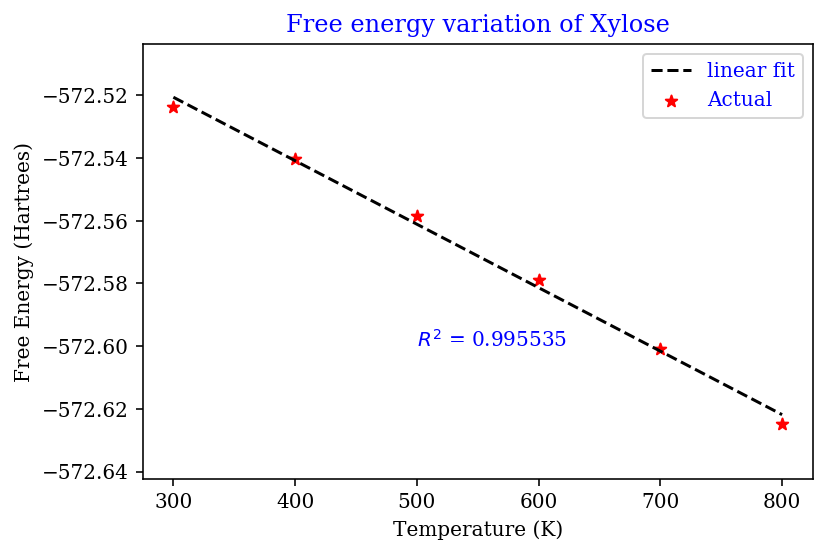

In [59]:
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "serif"
plt.rcParams['text.color'] = "blue"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

df_new = pd.DataFrame([df_all['300K'] + df_all['electronic_energy'],df_all['400K'] + df_all['electronic_energy'],df_all['500K'] + df_all['electronic_energy'],df_all['600K'] + df_all['electronic_energy'], df_all['700K'] + df_all['electronic_energy'],df_all['800K'] + df_all['electronic_energy']])
#df_new.head()
X = [300.0, 400.0, 500.0, 600.0, 700.0, 800.0]
Y = df_new[0]
#fit = np.polyfit(X,Y,1)
#fit_fn = np.poly1d(fit)
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
#print(intercept)
Y1 = [slope * float(x) + intercept for x in X]
r_2 = r_value**2

fig, ax = plt.subplots()
ax.scatter( X, Y, marker = '*', color = 'red', label = 'Actual')
ax.plot(X, Y1, '--k', label = 'linear fit')
plt.xlabel('Temperature (K)')
plt.ylabel('Free Energy (Hartrees)')
plt.title('Free energy variation of Xylose')
plt.text(500, -572.60, '$ R^2 $ = %f' %r_2)
plt.legend()

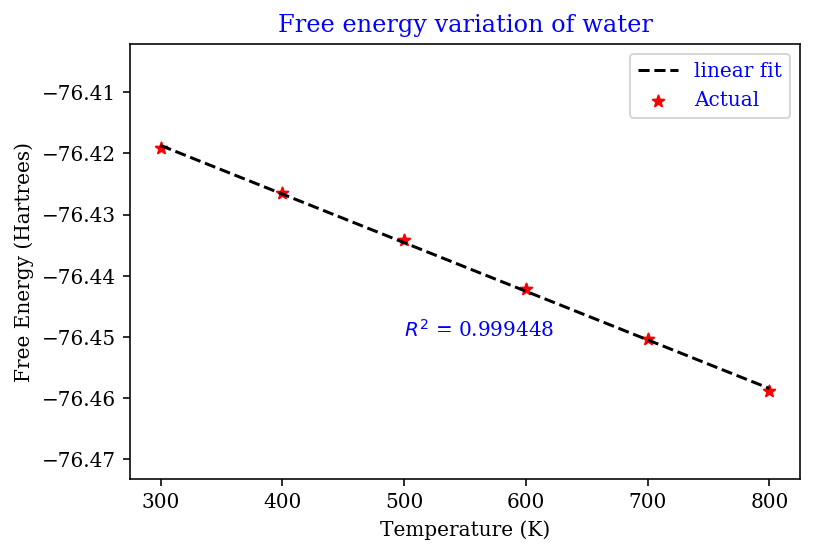

In [60]:
X = [300.0, 400.0, 500.0, 600.0, 700.0, 800.0]
Y = df_new[1]
#fit = np.polyfit(X,Y,1)
#fit_fn = np.poly1d(fit)
slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)
#print(intercept)
Y1 = [slope * float(x) + intercept for x in X]
r_2 = r_value**2

fig, ax = plt.subplots()
ax.scatter( X, Y, marker = '*', color = 'red', label = 'Actual')
ax.plot(X, Y1, '--k', label = 'linear fit')
plt.xlabel('Temperature (K)')
plt.ylabel('Free Energy (Hartrees)')
plt.title('Free energy variation of water')
plt.text(500, -76.45, '$ R^2 $ = %f' %r_2)
plt.legend()

In [65]:
def build_free_energy_dict(free_energy_path, T):
    """
    Build a dictionary of free energy at a given temperature for all the species 
    present in the mechanism. It reads the file free_energy_path which is basically
    a library of gibbs free energy correction at different molecules at different temperatures.
    Parameters
    ----------
    completereactionlist : str
                           path to the file `free_energy_library.dat`
    T                    : float
                           temperature to calculate free energy
    Returns
    -------
    free_energy.    : dict
                    a dictionary where keys are unique species and values
                    are free energy of species at a given temperature 
                    build from free_energy_library.dat
    """
    
    df = pd.read_csv(free_energy_path, sep = '\t')

    if "{}K".format(T) in df.columns:
        df["Free Energy @{}K".format(T)] = df['electronic_energy'] + df["{}K".format(T)]
    else:
        temp_low = math.floor(T / 100.0)* 100
        temp_high = math.ceil(T / 100.0)* 100
        df["{}K".format(T)] = (df["{}K".format(temp_high)] - df["{}K".format(temp_low)])*(temp - temp_low)/(temp_high - temp_low) + df["{}K".format(temp_low)]
        df["Free Energy @{}K".format(T)] = df['electronic_energy'] + df["{}K".format(T)]
    print(df.head())
    
    free_energy = dict([(i, a) for i, a  in zip(df.smiles, df['Free Energy @' + str(T) +'K'])])
    
    return free_energy
print(file_free_energy)

/Users/chowdhury/Documents/kinexns/examples/../kinexns/data/free_energy_library.dat


In [66]:
free_energy_dict = build_free_energy_dict(file_free_energy, temp)
print(free_energy_dict)

   Structure ID                              smiles  electronic_energy  \
0             1  O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O        -572.654636   
1             2                                   O         -76.422977   
2             3            OC1=COC[C@@H](O)[C@@H]1O        -496.193201   
3             4           OC1=C[C@@H](O)[C@H](O)OC1        -496.205201   
4             5        O[C@H]1C=CO[C@@H](O)[C@@H]1O        -496.204142   

       300K      400K      500K      600K      700K      800K      573K  \
0  0.130831  0.114449  0.096034  0.075704  0.053580  0.029778  0.081193   
1  0.003836 -0.003547 -0.011258 -0.019238 -0.027448 -0.035861 -0.017083   
2  0.103466  0.088156  0.071087  0.052368  0.032109  0.010414  0.057422   
3  0.104026  0.088926  0.072080  0.053591  0.033566  0.012107  0.058583   
4  0.104043  0.088886  0.071984  0.053439  0.033355  0.011835  0.058446   

   Free Energy @573K  
0        -572.573443  
1         -76.440061  
2        -496.135779  
3        -49

In [67]:
temperature = [300, 373, 473, 573, 673, 773]
import matplotlib.pyplot as plt

reactants_list1, products_list1, unique_species1 = build_species_list('/Users/chowdhury/Documents/kmpy/kmpy/data/complete_reaction_list.dat')
reac_prod_list1 = [react + prod for react, prod in zip(reactants_list1, products_list1)]

for temp in temperature:
    df = pd.read_csv('/Users/chowdhury/Documents/kmpy/kmpy/data/free_energy_library.dat', sep = '\t')
    #df = pd.read_csv(file_free_energy, sep = '\t')
    if str(temp)+'K' in df.columns:
        df['Free Energy @' + str(temp) +'K'] = df['electronic_energy'] + df[str(temp)+'K']
    else:
        temp_low = math.floor(temp / 100.0)* 100
        temp_high = math.ceil(temp / 100.0)* 100
        df[str(temp)+'K'] = (df[str(temp_high)+'K'] - df[str(temp_low)+'K'])*(temp - temp_low)/(temp_high - temp_low) + df[str(temp_low)+'K']
        df['Free Energy @' + str(temp) +'K'] = df['electronic_energy'] + df[str(temp)+'K']
    
    free_energy_dict1 = dict([(i, a) for i, a  in zip(df.smiles, df['Free Energy @' + str(temp) +'K'])])
#    print (free_energy_dict)
    mol_change = []
    free_energy_change = []

    for i, item in enumerate (reac_prod_list1):
        n_reac = 0
        n_prod = 0
        reac_free_energy = 0
        prod_free_energy = 0
        for entry in item:
        
            #print(entry[0])
            if float(entry[0]) < 0:
                n_reac = n_reac + abs(float(entry[0]))
                reac_free_energy = free_energy_dict1[entry[1]] + reac_free_energy
            else:
                prod_free_energy = free_energy_dict1[entry[1]] + prod_free_energy
                n_prod = n_prod + abs(float(entry[0]))
        #print(n_reac)
        mol_change.append(n_prod - n_reac)
        #print(mol_change)
        free_energy_change.append((prod_free_energy - reac_free_energy) * 2625.5)
    plt.plot(free_energy_change, label = '%sK' %temp)

plt.legend()
plt.xlim(0,10)
plt.ylim(-90,100)
plt.xlabel('Reaction Number')
plt.ylabel('Free Energy Change (kJ/mol)')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/chowdhury/Documents/kmpy/kmpy/data/complete_reaction_list.dat'

In [68]:
def build_free_energy_change(complete_list, free_energy):
    """
    Calculate the reverse rate constants of all the reactions. There are two steps 
    doing this
    1. Calculate the change in free energy for each reaction
            delG = G(products) - G(reactanat)
    This is calculated from the complete lists of reactions and free_energy_dict
    2. Use delG to calculate the equlilibrium constant
            Keq = exp (- delG/Gas Const * Temp)
    3. Use the following equation to calculate the reverse rate constant
            Keq = Kf / Kr * (Gas Const * Temp / Pressure)^n
    where n = total number of product molecules - total number of reactant molecules
    ----------
    complete_list        : list
                           A list of all the reactions with reactant and 
                         product species and their stoichimetric coeffs
    free_energy          : dict
                          A dictionary of free energies of all the species
                          at a given temperature, obtained from 
                          build_free_energy_dict function
    forward_rate         : A list of forward rate constants for all the reactions
                         obtained from build_forward_reaction_rates
    T                    : float
                           temperature to calculate free energy
    Returns
    -------
     reverse_rates       : list
                         A list of reverse rate constants
    """
    
    
    mol_change = []
    gibbs_energy_list = []

    for i, item in enumerate (complete_list):
        n_reac = 0
        n_prod = 0
        reac_free_energy = 0
        prod_free_energy = 0
        for entry in item:
        
            if float(entry[0]) < 0:
                n_reac = n_reac + abs(float(entry[0]))
                reac_free_energy = abs(float(entry[0])) * free_energy[entry[1]] + reac_free_energy
            else:
                prod_free_energy = abs(float(entry[0])) * free_energy[entry[1]] + prod_free_energy
                n_prod = n_prod + abs(float(entry[0]))
        #print(n_reac)
        mol_change.append(n_prod - n_reac)
        gibbs_energy_list.append((prod_free_energy - reac_free_energy) * HT_JL)
    
    return gibbs_energy_list, mol_change
    

In [69]:
gibbs_energy, mol = build_free_energy_change(reac_prod_list, free_energy_dict)
gibbs_energy

[-6.293953619833474,
 -34.75227321973887,
 -32.32967185957523,
 15.652259565004215,
 21.4214807549626,
 -37.87716957504864,
 -50.01669392511337,
 -23.949627214829917,
 -23.770305565252812,
 18.74137035483423,
 -42.04549213994474,
 -30.245103625125182,
 -36.465937069859706,
 -17.737851745117297,
 -75.88926359512377,
 -46.19617134517193,
 -38.088811130042615,
 -7.8272456201410705,
 -55.937616504975296,
 -26.986674339997336,
 -55.153642205104035,
 -10.524553044882765,
 -49.80602380529305,
 -0.010764550032519082,
 -38.41387428486962,
 -40.17802650034355,
 -114.27087048461817,
 -35.75568680996946,
 -37.73119177505902,
 -44.28278570981212,
 -48.699296789741254,
 -32.450471115037345,
 -22.720788195013256,
 0.0,
 -64.40540536007813,
 -9.605470514689983,
 -40.44343829530922,
 -36.1504307350026,
 -67.72012536478925,
 -11.333548359753536,
 -9.878732555062669,
 -42.385494390056394]

Now, after all these, we can calculate the thermodynamic equilibrium constants using the folloing equation

$ K_{eq} = exp (-\frac{\Delta G}{RT})$

In [70]:
equilibrium_constants = [np.exp(-n * 1000 /(GAS_CONST * temp)) for n in gibbs_energy]
equilibrium_constants

[3.7478059392258545,
 1472.7506416232027,
 885.6804806791698,
 0.03741877593758052,
 0.011146763344024589,
 2837.9506739118815,
 36281.313688001035,
 152.51943852384215,
 146.88507128199748,
 0.019564839154529386,
 6807.733727798836,
 571.7960032659608,
 2110.3395575347386,
 41.4037547767535,
 8285330.418735665,
 16270.161103266519,
 2966.8717202066696,
 5.170790414966751,
 125734.18964990876,
 288.5308140442488,
 106655.62462760144,
 9.108611361621232,
 34711.84011535467,
 1.0022621531119518,
 3176.380884128338,
 4600.005753695206,
 26139712504.598995,
 1818.040849465135,
 2752.308022872552,
 10888.33445575511,
 27515.970516317542,
 908.4259314788559,
 117.84204558039943,
 1.0,
 743711.175882265,
 7.510444601876033,
 4863.558784626394,
 1975.1030764204047,
 1491368.1553577667,
 10.79450650468792,
 7.953844483952876,
 7311.361568560388]

Finally, we can calculate the reverse rate constants using the following equaion


$ K_{eq} = \frac{k_f}{k_r} (\frac{1000RT}{P})^{\Delta n}$, ${\Delta n}$ = number of product molecules - number of reactant molecules

multiplied by 1000 to convert it from $ \frac{m^3}{mol*s}$ to $ \frac{L}{mol*s}$

In [71]:
reverse_rate_constants = [(a / b) * (GAS_CONST * temp * 1000/ PR_ATM)**c if c < 3 else 0 for (a, b, c) in zip(forward_rate_constants, equilibrium_constants, mol)]

print(reverse_rate_constants)

[1.1379057686786213e-05, 2.8957040503698464e-08, 9.975478106112853e-09, 0.0009483448135351068, 0.0021052930416568835, 4.968383801174684e-09, 7.237684185252314e-07, 1.0116131013377096e-05, 2.903392401223406e-07, 0.0011994580236422835, 2.071177975016889e-09, 2.6983515333811192e-06, 1.2443148751217059e-05, 1.0300152778722192e-06, 1.7018063787669946e-12, 2.6211479843779145e-09, 4.75248999165167e-09, 4.538417035284514e-06, 1.121415598737014e-10, 9.386354500770732e-05, 1.4466247116184548e-08, 1.5479887764458226e-06, 2.5452658846853797e-10, 1.4068203725958322e-05, 4.857435800295422e-07, 0.00011515532700999932, 2.5310227524957375e-15, 8.486644415321152e-07, 5.122983343296196e-09, 2.411688319888338e-06, 5.607313110322332e-08, 1.5521384482984407e-08, 0.00022283446371496138, 9.070586400466592e-07, 2.0746045941336703e-09, 1.877389276431721e-06, 5.399188165050525e-06, 1.3295138539085037e-05, 2.737047803138508e-07, 0.002508917386671746, 0.0033014561804623186, 1.240615214472644e-10]


In [73]:
def build_rate_eqn(k_mat, r_dict, s_indices, human, forward):

    """ This function writes the list of rate expressions for each reaction.
    Parameters
    ----------
    kmat               : list
                         A list of reaction rate contstants (k_forward or k_reverse)
    r_dict             : dictionary
                         reactant or product directory
    s_indices          : dict
                         the reverse of speciesindices (keys are the indices
                         and values are the species)
    human              : str, optional
                         indicate whether the output of this function should
                         be formatted for a human to read ('yes'). Default
                         is 'no'
    forward             : str
                        reaction type,if 'yes', it is forward reaction
                        default is 'yes'
    Returns
    -------
    rates_list : list
                A list of the rate expressions for all the reactions in the mecahnism
    """

    rates_list = []
    for i, line in enumerate(k_mat):
        if forward == 'yes':
            rate = 'rate_f[%s] = kf(T,%s) ' % (i, i)
        else:
            rate = 'rate_r[%s] = kr(T,%s) ' % (i, i)
        concentrations = ''
        for entry in r_dict[i]:
            if entry == 'n':   # if there is no reaction
                concentrations = '* 0'
                break
            else:
                if human == 'no':
                    concentrations += '* y[%s]**%s ' % (entry[0], entry[1])
                elif human == 'yes':
                    concentrations += '* [%s]**%s ' % \
                        (s_indices[entry[0]], entry[1])
                else:
                    raise ValueError('human must be a string: yes or no')
        rate += concentrations

        #rate = rate_reactant + rate_product
        rates_list.append(rate)
        
    return rates_list


rates_f = build_rate_eqn(forward_rate_constants, reac_dict, indices_to_species, human = 'no', forward = 'yes')
rates_r = build_rate_eqn(reverse_rate_constants, prod_dict, indices_to_species, human = 'no', forward = 'no')


print(rates_r)

['rate_r[0] = kr(T,0) * y[9]**1.0 * y[38]**1.0 ', 'rate_r[1] = kr(T,1) * y[9]**1.0 * y[39]**1.0 ', 'rate_r[2] = kr(T,2) * y[9]**1.0 * y[40]**1.0 ', 'rate_r[3] = kr(T,3) * y[29]**1.0 ', 'rate_r[4] = kr(T,4) * y[33]**1.0 ', 'rate_r[5] = kr(T,5) * y[23]**1.0 ', 'rate_r[6] = kr(T,6) * y[22]**1.0 * y[21]**1.0 ', 'rate_r[7] = kr(T,7) * y[9]**1.0 * y[13]**1.0 ', 'rate_r[8] = kr(T,8) * y[9]**1.0 * y[36]**1.0 ', 'rate_r[9] = kr(T,9) * y[30]**1.0 ', 'rate_r[10] = kr(T,10) * y[31]**1.0 ', 'rate_r[11] = kr(T,11) * y[9]**1.0 * y[12]**1.0 ', 'rate_r[12] = kr(T,12) * y[6]**1.0 * y[19]**1.0 ', 'rate_r[13] = kr(T,13) * y[9]**1.0 * y[37]**1.0 ', 'rate_r[14] = kr(T,14) * y[15]**1.0 ', 'rate_r[15] = kr(T,15) * y[9]**1.0 * y[37]**1.0 ', 'rate_r[16] = kr(T,16) * y[16]**1.0 ', 'rate_r[17] = kr(T,17) * y[1]**1.0 ', 'rate_r[18] = kr(T,18) * y[7]**1.0 ', 'rate_r[19] = kr(T,19) * y[4]**1.0 * y[22]**1.0 ', 'rate_r[20] = kr(T,20) * y[9]**1.0 * y[3]**1.0 ', 'rate_r[21] = kr(T,21) * y[5]**1.0 ', 'rate_r[22] = kr(T,2

In [74]:
#rate_matrix = np.zeros(len(reac_prod_list), dtype = float)
rate_list = []
for rxnindex, reac_list in enumerate(reac_prod_list):
    #rate = ''
    rate_f = 'kf[%s] ' %rxnindex
    rate_r = '- kr[%s]' %rxnindex
    concentration_f = ''
    concentration_r = ''
    for x in range (len(reac_list)):
        species = reac_list[x][1]
        for i in range (len(unique_species)):
            if i == speciesindices[species]:
                reac_matrix[rxnindex][i] = float(reac_list[x][0])
                if float(reac_list[x][0]) < 0:
                    if abs(float(reac_list[x][0])) == 1:
                        concentration_f += '* y[%s] ' % (i)
                    else:    
                        concentration_f += '* y[%s] ** %s ' % (i, abs(float(reac_list[x][0])))
                else:
                    if abs(float(reac_list[x][0])) == 1:
                        concentration_r += '* y[%s] ' % (i)
                    else:    
                        concentration_r += '* y[%s] ** %s ' % (i, float(reac_list[x][0]))
                    
    rate = rate_f + concentration_f + rate_r + concentration_r
    #print(rate)
    rate_list.append(rate)
print(reac_matrix[1])
#print(rate_list)


        

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0. -1.]


In [75]:
def build_dydt_list(rates_forward, rates_reverse, specieslist, species_rxns, human='no'):
    """This function returns the list of dydt expressions generated for all
    the reactions from rates_list.
    Parameters
    ----------
    rates_list         : list
                         the output of build_rates_list()
    specieslist        : list
                         a list of all the species in the kinetic scheme
    species_rxns       : dict
                         dictionary where keys that are the model species and
                         values are the reactions they are involved in
    human              : str, optional
                         indicate whether the output of this function should
                         be formatted for a human to read ('yes'). Default
                         is 'no'
    Returns
    -------
    dydt_expressions : list
                       expressions for the ODEs expressing the concentration
                       of each species with time
    """
    dydt_expressions = []
    for species in specieslist:
        rate_formation = 'd[%s]/dt = ' % (species)
        # "entry" is [reaction#, sign of that reaction, coefficient]
        for entry in species_rxns[species]:
            if human == 'no':
                rate_formation += '%s*%s' % \
                    (entry[2], rates_forward[entry[0]].split(' = ')[1])
                rate_formation += '%s*%s' % \
                    (entry[3], rates_reverse[entry[0]].split(' = ')[1])
            elif human == 'yes':
                rate_formation += '%s*rate_f[%s] ' % (entry[2], entry[0])
                rate_formation += '%s*rate_r[%s] ' % (entry[3], entry[0])
            else:
                raise ValueError('human must be a string: yes or no')
        dydt_expressions.append(rate_formation)
    return dydt_expressions


In [76]:
dydt_list = build_dydt_list(rates_f, rates_r, unique_species, reac_species, human='no')

In [77]:
dydt_list

['d[C=C(O)C=O]/dt = +1*kf(T,32) * y[26]**1.0 -1*kr(T,32) * y[22]**1.0 * y[0]**1.0 +1*kf(T,38) * y[32]**1.0 -1*kr(T,38) * y[9]**1.0 * y[0]**1.0 ',
 'd[C=C(O)[C@@H](O)[C@H](O)C=O]/dt = +1*kf(T,17) * y[38]**1.0 -1*kr(T,17) * y[1]**1.0 -1*kf(T,18) * y[1]**1.0 +1*kr(T,18) * y[7]**1.0 ',
 'd[C=O]/dt = +1*kf(T,39) * y[29]**1.0 -1*kr(T,39) * y[28]**1.0 * y[2]**1.0 ',
 'd[CC(=O)/C=C(/O)C=O]/dt = +1*kf(T,20) * y[7]**1.0 -1*kr(T,20) * y[9]**1.0 * y[3]**1.0 -1*kf(T,21) * y[3]**1.0 +1*kr(T,21) * y[5]**1.0 ',
 'd[CC(=O)C=O]/dt = +1*kf(T,19) * y[7]**1.0 -1*kr(T,19) * y[4]**1.0 * y[22]**1.0 -1*kf(T,33) * y[4]**1.0 +1*kr(T,33) * y[4]**1.0 +1*kf(T,33) * y[4]**1.0 -1*kr(T,33) * y[4]**1.0 ',
 'd[CC(=O)CC(=O)C=O]/dt = +1*kf(T,21) * y[3]**1.0 -1*kr(T,21) * y[5]**1.0 ',
 'd[CC(=O)CO]/dt = +1*kf(T,12) * y[31]**1.0 -1*kr(T,12) * y[6]**1.0 * y[19]**1.0 ',
 'd[CC(=O)[C@@H](O)[C@H](O)C=O]/dt = +1*kf(T,18) * y[1]**1.0 -1*kr(T,18) * y[7]**1.0 -1*kf(T,19) * y[7]**1.0 +1*kr(T,19) * y[4]**1.0 * y[22]**1.0 -1*kf(T,20) 

In [41]:
import re

dydt_expressions = []
for species in unique_species:
    rate_equation = 'dy[%i]/dt = ' % (speciesindices[species])
    i = speciesindices[species]
    for j in range (len(rate_list)):
        if reac_matrix[j][i] > 0:
            if reac_matrix[j][i] == 1.0:
                rate_equation += '+ %s' %(rate_list[j])
            else:
                rate_equation += '+ %1.2f * %s' %(reac_matrix[j][i], re.split('-', rate_list[j])[0])
                rate_equation += '- %1.2f * %s' %(reac_matrix[j][i], re.split('-', rate_list[j])[1])
        elif reac_matrix[j][i] < 0:
            if abs(reac_matrix[j][i]) == 1.0:
                rate_equation += '- %s' %(re.split('-', rate_list[j])[0])
                rate_equation += '+ %s' %(re.split('-', rate_list[j])[1])
            else:
                rate_equation += '- %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_list[j])[0])
                rate_equation += '+ %1.2f * %s' %(abs(reac_matrix[j][i]), re.split('-', rate_list[j])[1])
        else:
            pass
    dydt_expressions.append(rate_equation)
    
print(dydt_expressions[speciesindices['O[C@H]1[C@H](O)CO[C@@H](O)[C@@H]1O']])
        
#     rate_formation = 'd[%s]/dt = ' % (species)
#     # "entry" is [reaction#, sign of that reaction, coefficient]
#     for entry in species_rxns[species]:
#         if human == 'no':
#             rate_formation += '%s*%s' % \
#             (entry[2], rates_forward[entry[0]].split(' = ')[1])
#             rate_formation += '%s*%s' % \
#             (entry[3], rates_reverse[entry[0]].split(' = ')[1])
#         elif human == 'yes':
#             rate_formation += '%s*rate_f[%s] ' % (entry[2], entry[0])
#             rate_formation += '%s*rate_r[%s] ' % (entry[3], entry[0])
#         else:
#             raise ValueError('human must be a string: yes or no')
#     dydt_expressions.append(rate_formation)


dy[41]/dt = - kf[0] * y[41] +  kr[0]* y[9] * y[38] - kf[1] * y[41] +  kr[1]* y[9] * y[39] - kf[2] * y[41] +  kr[2]* y[9] * y[40] - kf[3] * y[41] +  kr[3]* y[29] 


In [ ]:
a='kf(0) * y[0]**1.0 - kr(0)* y[1]**1.0 * y[2]**2.0'
import re
print(re.split('-', a))